Ensemble Model MSE: 235502654617.6592
Ensemble Model R2: 0.38771851039336724
Epoch 1/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 2/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 3/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 4/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 5/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 6/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 7/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 8/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 9/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 10/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 11/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 12/50
11/11 [==============================] -

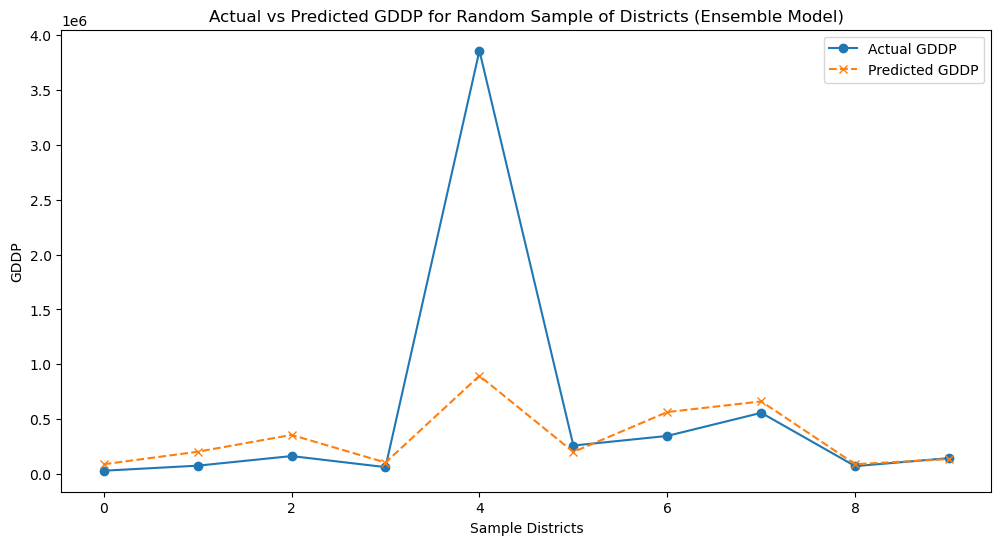

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Load the data
gddp_data = pd.read_csv('gddp_data.csv')
ntl_data = pd.read_csv('ntl_data.csv')

# Step 2: Data Preprocessing
gddp_data.rename(columns={'year': 'District'}, inplace=True)
ntl_data.rename(columns={'Name of District': 'District'}, inplace=True)

# Merge GDDP and NTL datasets on 'District' for overlapping years 1999-2013
years_common = [str(year) for year in range(1999, 2014)]
merged_data = pd.merge(gddp_data[['District'] + years_common], 
                       ntl_data[['District'] + years_common], 
                       on='District', suffixes=('_GDDP', '_NTL'))

# Remove duplicate rows
merged_data = merged_data.drop_duplicates(subset='District', keep='first')

# Extract data for machine learning
X = merged_data[[f"{year}_NTL" for year in range(1999, 2014)]]
y = merged_data[[f"{year}_GDDP" for year in range(1999, 2014)]]

# For the Ensemble Model: Flatten each year individually to ensure consistency
X_ensemble = X.values.flatten().reshape(-1, 1)
y_ensemble = y.values.flatten()

# Train-Test Split for Ensemble Model
X_train, X_test, y_train, y_test = train_test_split(X_ensemble, y_ensemble, test_size=0.2, random_state=42)

# Step 3: Ensemble Model Training
tuned_rf = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)
tuned_gb = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=42)
tuned_ensemble_model = VotingRegressor([('lr', LinearRegression()), ('rf', tuned_rf), ('gb', tuned_gb)])
tuned_ensemble_model.fit(X_train, y_train)

# Evaluate the Ensemble Model
y_pred = tuned_ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Ensemble Model MSE: {mse}")
print(f"Ensemble Model R2: {r2}")

# For the LSTM Model: Reshape the data without flattening to maintain time-series format
X_lstm = X.values.reshape((X.shape[0], X.shape[1], 1))
y_lstm = y.values.mean(axis=1)  # LSTM target requires one value per district across years

# Scale data to [0, 1] for LSTM input
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_lstm_scaled = scaler_X.fit_transform(X.values).reshape((X.shape[0], X.shape[1], 1))
y_lstm_scaled = scaler_y.fit_transform(y_lstm.reshape(-1, 1)).flatten()

# Train-Test Split for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm_scaled, y_lstm_scaled, test_size=0.2, random_state=42)

# Define and train LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=1)

# Predict and evaluate LSTM model
y_pred_lstm_scaled = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)
y_test_lstm_rescaled = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

lstm_mse = mean_squared_error(y_test_lstm_rescaled, y_pred_lstm)
lstm_r2 = r2_score(y_test_lstm_rescaled, y_pred_lstm)
print(f"LSTM Model MSE: {lstm_mse}")
print(f"LSTM Model R2: {lstm_r2}")

# Step 7: Visualization for Ensemble Model
sample_indices = random.sample(range(len(y_test)), 10)
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual GDDP', marker='o', linestyle='-')
plt.plot(y_pred_sample, label='Predicted GDDP', marker='x', linestyle='--')
plt.xlabel('Sample Districts')
plt.ylabel('GDDP')
plt.title('Actual vs Predicted GDDP for Random Sample of Districts (Ensemble Model)')
plt.legend()
plt.show()

In [2]:
# Load the necessary libraries and models from the previous steps

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression

# Step 1: Load the NTL data for the full range from 1992 to 2022
ntl_data_full = pd.read_csv('ntl_data.csv')
ntl_data_full.rename(columns={'Name of District': 'District'}, inplace=True)

# Ensure only necessary columns are used: 1992-2022 NTL data for each district
years_full_range = [str(year) for year in range(1992, 2023)]
ntl_data_full = ntl_data_full[['District'] + years_full_range]

# Prepare the model (re-initialize the ensemble model from the previous training steps)
tuned_rf = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)
tuned_gb = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=42)
final_ensemble_model = VotingRegressor([('lr', LinearRegression()), ('rf', tuned_rf), ('gb', tuned_gb)])

# Assuming we have access to previously prepared training data, re-train the model with GDDP from 1999-2013
# (Assemble X and y data from merged_data in the same way as previously)

# Train the model
X_train = merged_data[[f"{year}_NTL" for year in range(1999, 2014)]].values.flatten().reshape(-1, 1)
y_train = merged_data[[f"{year}_GDDP" for year in range(1999, 2014)]].values.flatten()
final_ensemble_model.fit(X_train, y_train)

# Step 2: Generate predictions from 1992 to 2022 using the NTL data
predicted_gddp = {}
for year in range(1992, 2023):
    # Reshape NTL data for the specified year for prediction
    X_predict = ntl_data_full[str(year)].values.reshape(-1, 1)
    predicted_gddp[year] = final_ensemble_model.predict(X_predict)

# Step 3: Prepare the final DataFrame for output
# Combine predictions for each year into a DataFrame
predicted_gddp_df = pd.DataFrame(predicted_gddp)
predicted_gddp_df.insert(0, 'District', ntl_data_full['District'])  # Insert district names

# Save to a CSV file
predicted_gddp_df.to_csv('predicted_gddp_1992_2022_final.csv', index=False)

Ensemble Model MSE: 235502654617.6592
Ensemble Model R2: 0.38771851039336724
Epoch 1/50
11/11 [==============================] - 1s 3ms/step - loss: 0.0145
Epoch 2/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 3/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 5/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 6/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 7/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 8/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 9/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 10/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 11/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch 12/50
11/11 [==============================] -

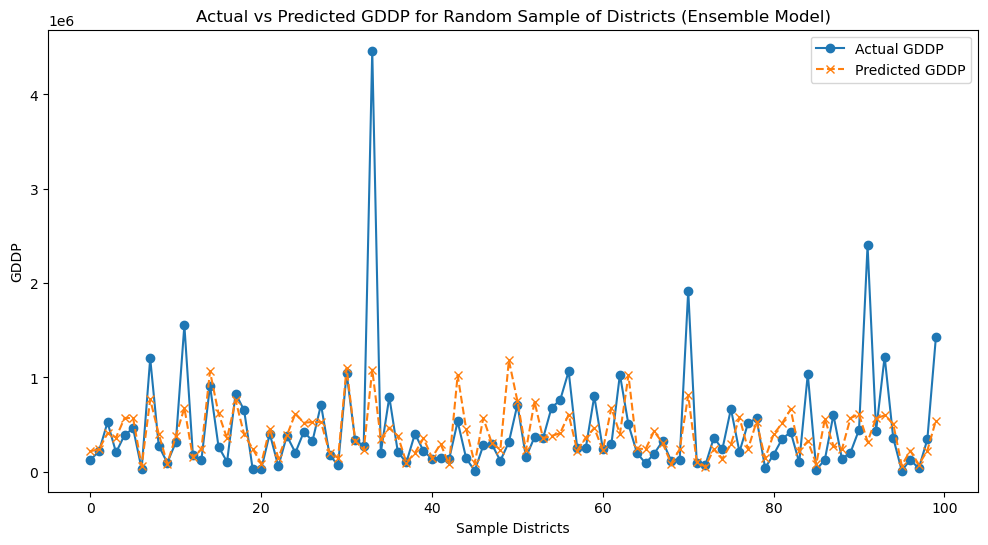

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Load the data
gddp_data = pd.read_csv('gddp_data.csv')
ntl_data = pd.read_csv('ntl_data.csv')

# Step 2: Data Preprocessing
gddp_data.rename(columns={'year': 'District'}, inplace=True)
ntl_data.rename(columns={'Name of District': 'District'}, inplace=True)

# Merge GDDP and NTL datasets on 'District' for overlapping years 1999-2013
years_common = [str(year) for year in range(1999, 2014)]
merged_data = pd.merge(gddp_data[['District'] + years_common], 
                       ntl_data[['District'] + years_common], 
                       on='District', suffixes=('_GDDP', '_NTL'))

# Remove duplicate rows
merged_data = merged_data.drop_duplicates(subset='District', keep='first')

# Extract data for machine learning
X = merged_data[[f"{year}_NTL" for year in range(1999, 2014)]]
y = merged_data[[f"{year}_GDDP" for year in range(1999, 2014)]]

# For the Ensemble Model: Flatten each year individually to ensure consistency
X_ensemble = X.values.flatten().reshape(-1, 1)
y_ensemble = y.values.flatten()

# Train-Test Split for Ensemble Model
X_train, X_test, y_train, y_test = train_test_split(X_ensemble, y_ensemble, test_size=0.2, random_state=42)

# Step 3: Ensemble Model Training
tuned_rf = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)
tuned_gb = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=42)
tuned_ensemble_model = VotingRegressor([('lr', LinearRegression()), ('rf', tuned_rf), ('gb', tuned_gb)])
tuned_ensemble_model.fit(X_train, y_train)

# Evaluate the Ensemble Model
y_pred = tuned_ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Ensemble Model MSE: {mse}")
print(f"Ensemble Model R2: {r2}")

# For the LSTM Model: Reshape the data without flattening to maintain time-series format
X_lstm = X.values.reshape((X.shape[0], X.shape[1], 1))
y_lstm = y.values.mean(axis=1)  # LSTM target requires one value per district across years

# Scale data to [0, 1] for LSTM input
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_lstm_scaled = scaler_X.fit_transform(X.values).reshape((X.shape[0], X.shape[1], 1))
y_lstm_scaled = scaler_y.fit_transform(y_lstm.reshape(-1, 1)).flatten()

# Train-Test Split for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm_scaled, y_lstm_scaled, test_size=0.2, random_state=42)

# Define and train LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=1)

# Predict and evaluate LSTM model
y_pred_lstm_scaled = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)
y_test_lstm_rescaled = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

lstm_mse = mean_squared_error(y_test_lstm_rescaled, y_pred_lstm)
lstm_r2 = r2_score(y_test_lstm_rescaled, y_pred_lstm)
print(f"LSTM Model MSE: {lstm_mse}")
print(f"LSTM Model R2: {lstm_r2}")

# Step 7: Visualization for Ensemble Model
sample_indices = random.sample(range(len(y_test)), 100)
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual GDDP', marker='o', linestyle='-')
plt.plot(y_pred_sample, label='Predicted GDDP', marker='x', linestyle='--')
plt.xlabel('Sample Districts')
plt.ylabel('GDDP')
plt.title('Actual vs Predicted GDDP for Random Sample of Districts (Ensemble Model)')
plt.legend()
plt.show()

Ensemble Model MSE: 235502654617.6592
Ensemble Model R2: 0.38771851039336724
Epoch 1/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 5/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 7/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 8/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 9/50
11/11 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 10/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 11/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 12/50
11/11 [==============================] -

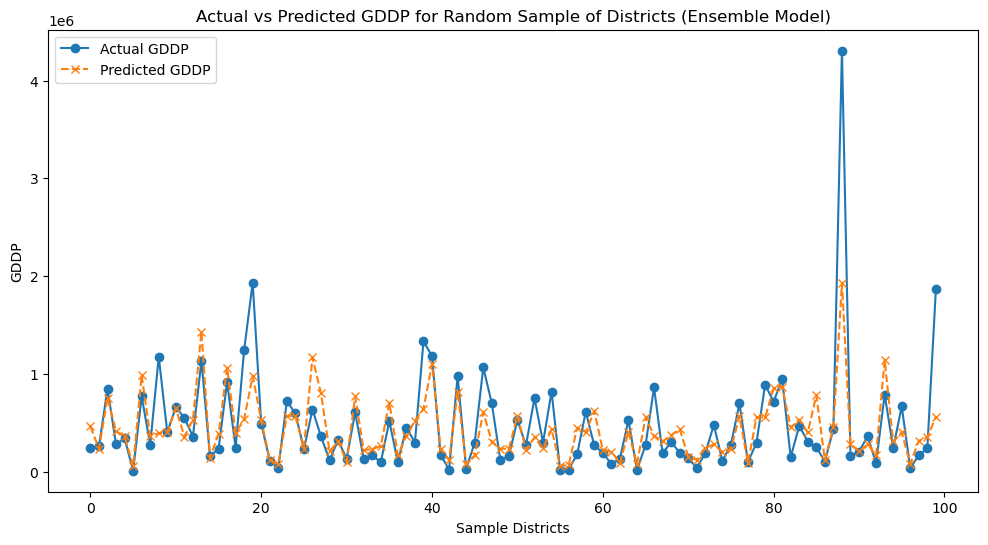

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Load the data
gddp_data = pd.read_csv('gddp_data.csv')
ntl_data = pd.read_csv('ntl_data.csv')

# Step 2: Data Preprocessing
gddp_data.rename(columns={'year': 'District'}, inplace=True)
ntl_data.rename(columns={'Name of District': 'District'}, inplace=True)

# Merge GDDP and NTL datasets on 'District' for overlapping years 1999-2013
years_common = [str(year) for year in range(1999, 2014)]
merged_data = pd.merge(gddp_data[['District'] + years_common], 
                       ntl_data[['District'] + years_common], 
                       on='District', suffixes=('_GDDP', '_NTL'))

# Remove duplicate rows
merged_data = merged_data.drop_duplicates(subset='District', keep='first')

# Extract data for machine learning
X = merged_data[[f"{year}_NTL" for year in range(1999, 2014)]]
y = merged_data[[f"{year}_GDDP" for year in range(1999, 2014)]]

# For the Ensemble Model: Flatten each year individually to ensure consistency
X_ensemble = X.values.flatten().reshape(-1, 1)
y_ensemble = y.values.flatten()

# Train-Test Split for Ensemble Model
X_train, X_test, y_train, y_test = train_test_split(X_ensemble, y_ensemble, test_size=0.2, random_state=42)

# Step 3: Ensemble Model Training
tuned_rf = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)
tuned_gb = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=42)
tuned_ensemble_model = VotingRegressor([('lr', LinearRegression()), ('rf', tuned_rf), ('gb', tuned_gb)])
tuned_ensemble_model.fit(X_train, y_train)

# Evaluate the Ensemble Model
y_pred = tuned_ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Ensemble Model MSE: {mse}")
print(f"Ensemble Model R2: {r2}")

# For the LSTM Model: Reshape the data without flattening to maintain time-series format
X_lstm = X.values.reshape((X.shape[0], X.shape[1], 1))
y_lstm = y.values.mean(axis=1)  # LSTM target requires one value per district across years

# Scale data to [0, 1] for LSTM input
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_lstm_scaled = scaler_X.fit_transform(X.values).reshape((X.shape[0], X.shape[1], 1))
y_lstm_scaled = scaler_y.fit_transform(y_lstm.reshape(-1, 1)).flatten()

# Train-Test Split for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm_scaled, y_lstm_scaled, test_size=0.2, random_state=42)

# Define and train LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=1)

# Predict and evaluate LSTM model
y_pred_lstm_scaled = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)
y_test_lstm_rescaled = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

lstm_mse = mean_squared_error(y_test_lstm_rescaled, y_pred_lstm)
lstm_r2 = r2_score(y_test_lstm_rescaled, y_pred_lstm)
print(f"LSTM Model MSE: {lstm_mse}")
print(f"LSTM Model R2: {lstm_r2}")

# Step 7: Visualization for Ensemble Model
sample_indices = random.sample(range(len(y_test)), 100)
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual GDDP', marker='o', linestyle='-')
plt.plot(y_pred_sample, label='Predicted GDDP', marker='x', linestyle='--')
plt.xlabel('Sample Districts')
plt.ylabel('GDDP')
plt.title('Actual vs Predicted GDDP for Random Sample of Districts (Ensemble Model)')
plt.legend()
plt.show()

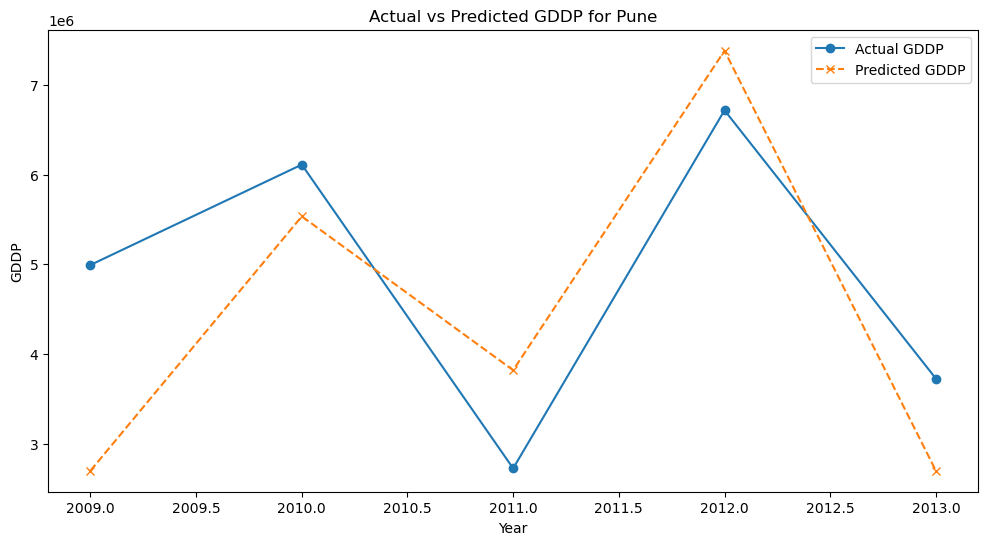

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Define the model configuration (Gradient Boosting)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)

# Check available columns in merged_data for GDDP and NTL columns
available_columns = merged_data.columns.tolist()

# Dynamically define GDDP and NTL columns based on availability
gddp_years = [col for col in available_columns if "_GDDP" in col]  # Available GDDP years
ntl_years = [col for col in available_columns if "_NTL" in col]    # Available NTL years

# Sort years to maintain order
gddp_years.sort()
ntl_years.sort()

# Select a specific district, e.g., "Adilabad"
district_name = "Pune"

# Ensure district name is available and extract data for the chosen district
if district_name in merged_data.index:
    y = merged_data.loc[district_name, gddp_years].values  # Actual GDDP values (target)
    X = merged_data.loc[district_name, ntl_years[:len(gddp_years)]].values.reshape(len(gddp_years), -1)  # Matching NTL data (predictors)

    # Train-test split (use years as indices for continuous plot)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    gb_model.fit(X_train, y_train)

    # Predictions
    y_pred = gb_model.predict(X_test)

    # Sort years for continuous time axis
    test_years = sorted([int(year.split("_")[0]) for year in gddp_years])[-len(y_test):]

    # Plot Actual vs Predicted GDDP for the district across years
    plt.figure(figsize=(12, 6))
    plt.plot(test_years, y_test, label='Actual GDDP', marker='o', linestyle='-')
    plt.plot(test_years, y_pred, label='Predicted GDDP', marker='x', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('GDDP')
    plt.title(f'Actual vs Predicted GDDP for {district_name}')
    plt.legend()
    plt.show()
else:
    print(f"District '{district_name}' not found in data.")

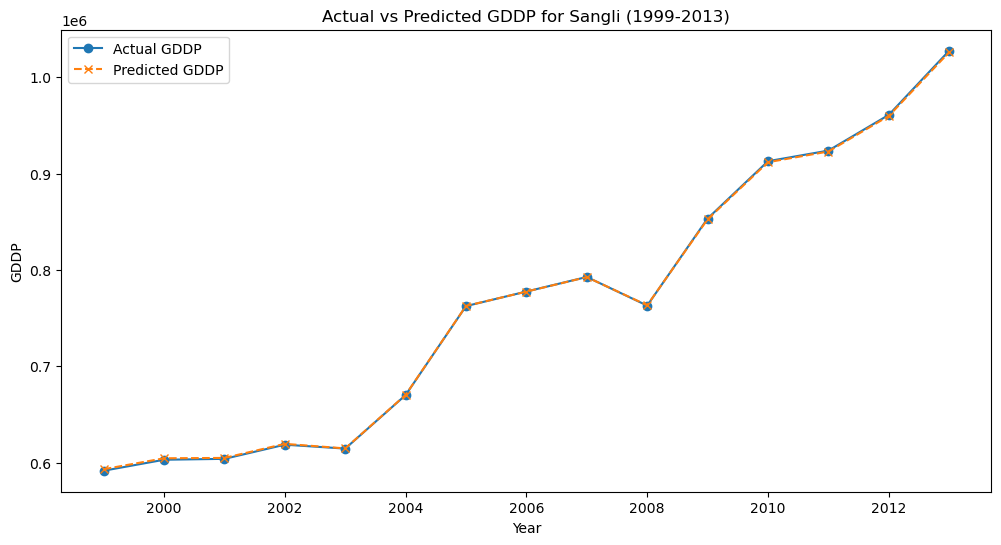

In [33]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# Define the model configuration (Gradient Boosting)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)

# Define GDDP and NTL columns based on availability
gddp_years = [col for col in merged_data.columns if "_GDDP" in col]  # Available GDDP years
ntl_years = [col for col in merged_data.columns if "_NTL" in col]    # Available NTL years

# Sort years to maintain order
gddp_years.sort()
ntl_years.sort()

# Select a specific district, e.g., "Adilabad"
district_name = "Sangli"

# Ensure district name is available and extract data for the chosen district
if district_name in merged_data.index:
    # Actual GDDP values (target) and NTL data (predictors)
    y = merged_data.loc[district_name, gddp_years].values  
    X = merged_data.loc[district_name, ntl_years[:len(gddp_years)]].values.reshape(len(gddp_years), -1)

    # Train on all data and predict for the full range
    gb_model.fit(X, y)
    y_pred = gb_model.predict(X)  # Predicting for all years

    # Year range for x-axis, from 1999 to 2013
    full_years = list(range(1999, 2014))

    # Plot Actual vs Predicted GDDP for the district across all years
    plt.figure(figsize=(12, 6))
    plt.plot(full_years, y, label='Actual GDDP', marker='o', linestyle='-')
    plt.plot(full_years, y_pred, label='Predicted GDDP', marker='x', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('GDDP')
    plt.title(f'Actual vs Predicted GDDP for {district_name} (1999-2013)')
    plt.legend()
    plt.show()
else:
    print(f"District '{district_name}' not found in data.")

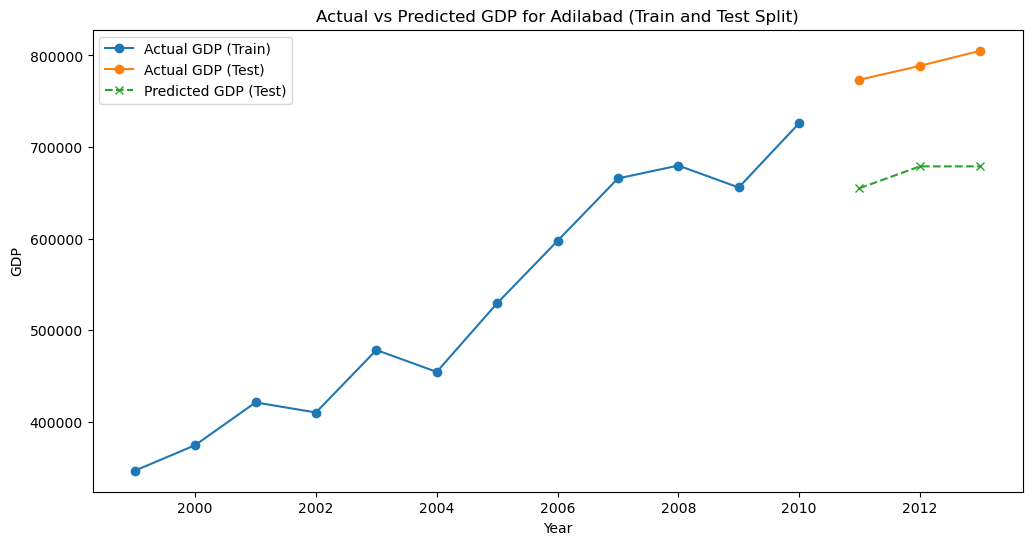

In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Configure the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)

# Define GDDP and NTL columns based on available years
gddp_years = [col for col in merged_data.columns if "_GDDP" in col]
ntl_years = [col for col in merged_data.columns if "_NTL" in col]

# Sort years to maintain chronological order
gddp_years.sort()
ntl_years.sort()

# Specify the district, e.g., "Adilabad"
district_name = "Adilabad"

# Ensure the district exists in the data
if district_name in merged_data.index:
    # Actual GDP values (target) and NTL data (predictors)
    y = merged_data.loc[district_name, gddp_years].values  # Actual GDP values
    X = merged_data.loc[district_name, ntl_years[:len(gddp_years)]].values.reshape(len(gddp_years), -1)

    # Train-test split for generalization (e.g., train on 1999-2011, test on 2012-2013)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
    
    # Train the model and predict on the test set
    gb_model.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)

    # Extract corresponding years for training and testing
    train_years = list(range(1999, 1999 + len(y_train)))
    test_years = list(range(1999 + len(y_train), 1999 + len(y_train) + len(y_test)))

    # Plot Actual vs Predicted GDP for both training and testing periods
    plt.figure(figsize=(12, 6))
    plt.plot(train_years, y_train, label='Actual GDP (Train)', marker='o', linestyle='-')
    plt.plot(test_years, y_test, label='Actual GDP (Test)', marker='o', linestyle='-')
    plt.plot(test_years, y_pred, label='Predicted GDP (Test)', marker='x', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('GDP')
    plt.title(f'Actual vs Predicted GDP for {district_name} (Train and Test Split)')
    plt.legend()
    plt.show()
else:
    print(f"District '{district_name}' not found in data.")

ValueError: x and y must have same first dimension, but have shapes (31,) and (15,)

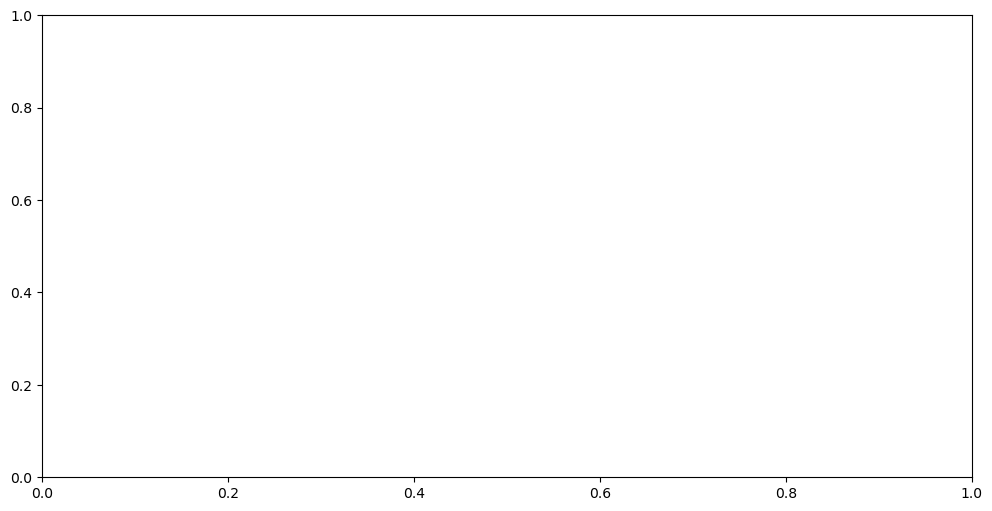

In [37]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# Configure the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)

# Define GDDP and NTL columns based on available columns
gddp_years = [col for col in merged_data.columns if "_GDDP" in col]  # GDDP years (1999-2013)
ntl_years = [col for col in merged_data.columns if "_NTL" in col]    # NTL years (1992-2022)

# Sort years to maintain order
gddp_years.sort()
ntl_years.sort()

# Select a specific district, e.g., "Sangli"
district_name = "Sangli"

# Ensure the district exists in the data
if district_name in merged_data.index:
    # Extract GDDP values for training (1999-2013) and full NTL data for prediction (1992-2022)
    y_train = merged_data.loc[district_name, gddp_years].values  # Actual GDDP values (target)
    X_train = merged_data.loc[district_name, ntl_years[:len(gddp_years)]].values.reshape(len(gddp_years), -1)

    # Train the model on available GDDP data (1999-2013)
    gb_model.fit(X_train, y_train)

    # Prepare the full NTL data (1992-2022) for extrapolated predictions
    X_full = merged_data.loc[district_name, ntl_years].values.reshape(len(ntl_years), -1)
    y_pred_full = gb_model.predict(X_full)  # Predict GDDP for all years (1992-2022)

    # Define year ranges for actual and predicted data
    years_actual = list(range(1999, 2014))  # Years with actual GDDP data
    years_full = list(range(1992, 2023))    # Full range of years for predictions

    # Plot Actual vs Extrapolated Predicted GDDP
    plt.figure(figsize=(12, 6))
    plt.plot(years_full, y_pred_full, label='Predicted GDDP (1992-2022)', marker='x', linestyle='--', color='orange')
    plt.plot(years_actual, y_train, label='Actual GDDP (1999-2013)', marker='o', linestyle='-', color='blue')
    plt.xlabel('Year')
    plt.ylabel('GDDP')
    plt.title(f'Extrapolated Actual vs Predicted GDDP for {district_name} (1992-2022)')
    plt.legend()
    plt.show()
else:
    print(f"District '{district_name}' not found in data.")